# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$ \nabla L(w, w_0) = -\frac{1}{N}\sum_{i=1}^N \frac{e^{-y_i(w^\top x_i+w_0)}}{1 + e^{-y_i(w^\top x_i + w_0)}}y_i x_i + \gamma sign(w) + 2\beta w $$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1.0 / X.shape[0] * np.sum(np.log(1 + np.exp((X.dot(w) + w0) * -y))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w, 2)

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    value = np.exp((X.dot(w) + w0) * -y)

    grad_w0 = -1.0 / X.shape[0] * ((value / (1 + value)).dot(y))
    grad_w = -1.0 / X.shape[0] * ((value / (1 + value) * y).dot(X)) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-3, tolerance=0.01, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        # you may additional properties if you wish
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        self.loss_history = []
        self.w = np.random.rand(X.shape[1])
        self.w0 = np.random.rand()
        
        for iter in range(self.max_iter):
            self.loss_history.append(loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta))

            addition_w, addition_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            if np.linalg.norm(addition_w) < self.tolerance:
                break
                
            self.w -= addition_w * self.learning_rate
            self.w0 -= addition_w0 * self.learning_rate
        
        return self
    
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.w0)
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))]).reshape((1, -1))

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

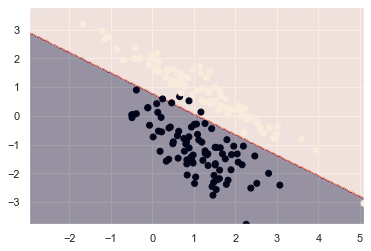

In [9]:
model = Logit(0,0, max_iter=100000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0.5, 1.0, 'Loss history')

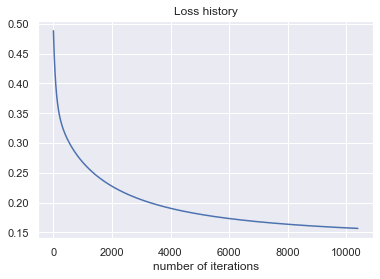

In [10]:
logit = Logit(0, 0.01, learning_rate=0.01, max_iter=100000)

logit.fit(X, y)
logit.predict(X)

plt.xlabel('number of iterations')
plt.plot(logit.loss_history)
plt.title('Loss history')

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [5]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Linear

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = SVC(C=0.1, kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.92      0.96      0.94        23

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



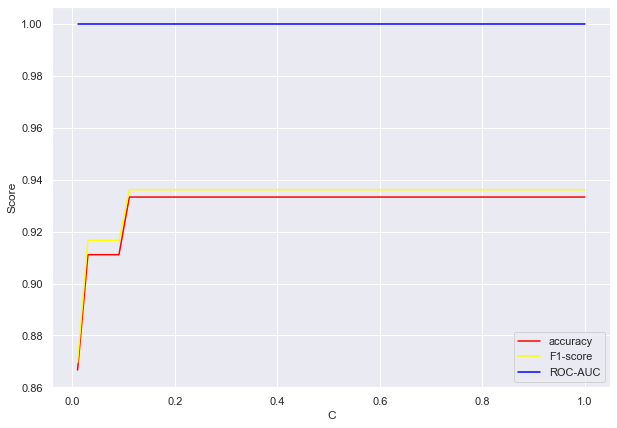

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

C_list = np.linspace(0.01, 1, 50)

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for c in C_list:
    model = SVC(C=c, kernel='linear', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_pred, y_test))
    roc_auc_hist.append(roc_auc_score(y_pred, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_pred, y_test))

plt.figure(figsize=(10, 7))
plt.xlabel("C")
plt.ylabel("Score")
plt.plot(C_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(C_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(C_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

*Выводы*

Линейный SVM не чувствителен к подбору гиперпараметров(параметру C регуляризации). При почти всех параметрах score остается очень высоким = 1.0(Такой хороший результат получен из-за того, что в данных нам пришли полностью линейно разделимые данные)

### Polynomial

In [9]:
model = SVC(C=0.1, kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.96      0.96      0.96        23

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



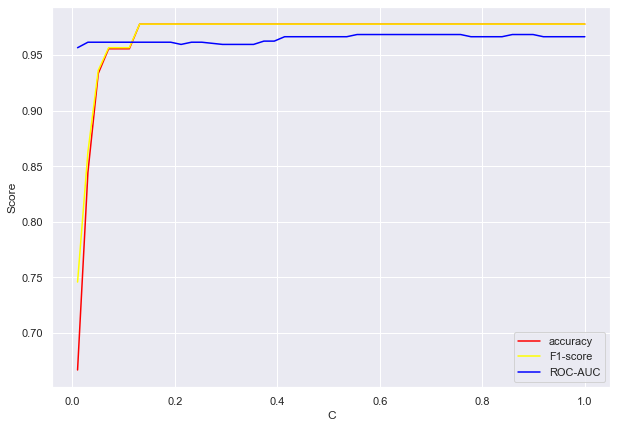

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

C_list = np.linspace(0.01, 1, 50)

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for c in C_list:
    model = SVC(C=c, kernel='poly', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_pred, y_test))
    roc_auc_hist.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_pred, y_test))

plt.figure(figsize=(10, 7))
plt.xlabel("C")
plt.ylabel("Score")
plt.plot(C_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(C_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(C_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

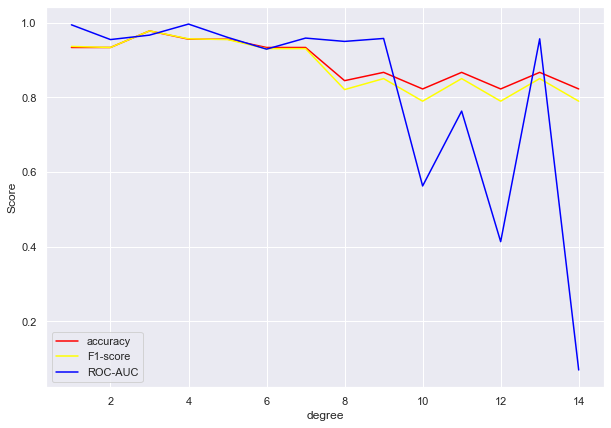

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

degree_list = list(range(1, 15))

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for degree in degree_list:
    model = SVC(degree=degree, kernel='poly', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_pred, y_test))
    roc_auc_hist.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_pred, y_test))

plt.figure(figsize=(10, 7))
plt.xlabel("degree")
plt.ylabel("Score")
plt.plot(degree_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(degree_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(degree_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

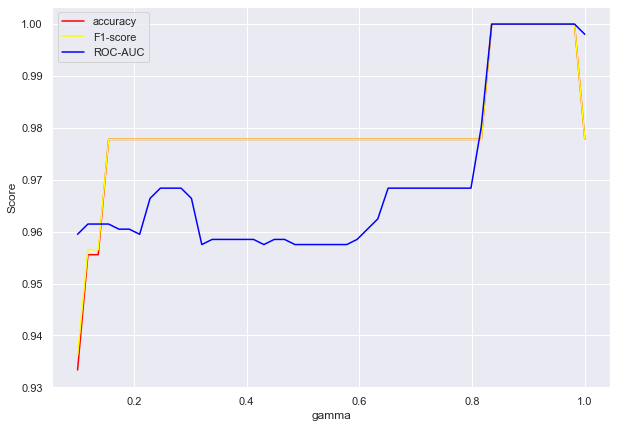

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

gamma_list = np.linspace(0.1, 1, 50)

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for gamma in gamma_list:
    model = SVC(gamma=gamma, kernel='poly', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_test, y_pred))
    roc_auc_hist.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 7))
plt.xlabel("gamma")
plt.ylabel("Score")
plt.plot(gamma_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(gamma_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(gamma_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

*Выводы*

Ядро polynomal также устойчиво к параметру C регуляризации, но неустойчиво к изменению степени полинома, т.к. при больших размерностях может переобучаться и находить несуществующие зависимости. Также, скорее всего, можно сказать, что неусточив к параметру gamma. При увеличении gamma score меняется.

### RBF

In [14]:
model = SVC(C=0.1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.88      1.00      0.94        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



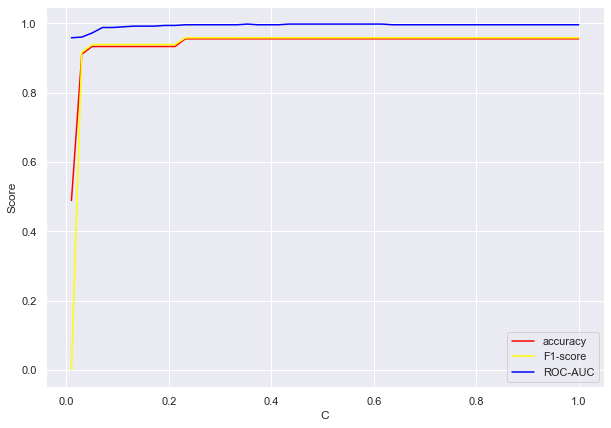

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

C_list = np.linspace(0.01, 1, 50)

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for c in C_list:
    model = SVC(C=c, kernel='rbf', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_pred, y_test))
    roc_auc_hist.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_pred, y_test))

plt.figure(figsize=(10, 7))
plt.xlabel("C")
plt.ylabel("Score")
plt.plot(C_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(C_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(C_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

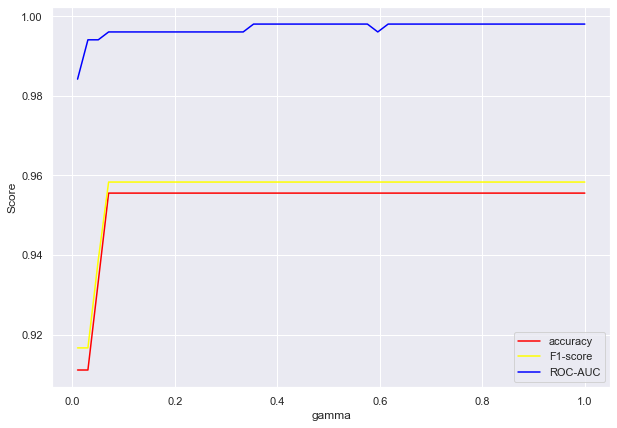

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score

gamma_list = np.linspace(0.01, 1, 50)

accuracy_hist = []
roc_auc_hist = []
f1_hist = []

for gamma in gamma_list:
    model = SVC(gamma=gamma, kernel='rbf', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_hist.append(accuracy_score(y_pred, y_test))
    roc_auc_hist.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    f1_hist.append(f1_score(y_pred, y_test))

plt.figure(figsize=(10, 7))
plt.xlabel("gamma")
plt.ylabel("Score")
plt.plot(gamma_list, accuracy_hist, color = "red", label='accuracy')
plt.plot(gamma_list, f1_hist, color = "yellow", label='F1-score')
plt.plot(gamma_list, roc_auc_hist, color = "blue", label='ROC-AUC')
plt.legend()

*Выводы*

RBF также устойчив к параметру регуляризации и везде показывает хороший результат. И к параметру gamma устойчив, при больших gamma результат сохраняется хорошим.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

*1. Build dataset*

In [35]:
# Blok, Bryusov, Chekhov, Dostoevsky, Gogol, Gorky
import glob
import nltk
import codecs
import pandas as pd

data_path = './lit/*'
text_paths = glob.glob(data_path)
text_paths

['./lit\\Blok',
 './lit\\Bryusov',
 './lit\\Chekhov',
 './lit\\Dostoevsky',
 './lit\\Gogol',
 './lit\\Gorky']

In [36]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\60130060\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
def divide_text(paths):
    df = pd.DataFrame()
    props = [5000, 15000, 8000, 11000, 20000, 3000]
    min_symbols = 15
    author_id = 0
    for path in paths:
        author = path.split('\\')[-1]
        texts = glob.glob(path + '/*.txt' )
        tokens = list()
        for text in texts:
            with codecs.open(text, 'r', 'utf-8') as txt:
                doc = txt.read().replace('\n', ' ')
                for token in nltk.sent_tokenize(doc, language='russian'):
                    if (len(token) >= min_symbols):
                        tokens.append(token)
        tokens = np.array(tokens)
        tokens = np.random.choice(tokens, props[author_id])
        df = pd.concat([df, pd.DataFrame(data={'sentence' : tokens, 'author' : author})])
        author_id += 1
    return df

In [38]:
df = divide_text(text_paths)
len(df[df['author'] == 'Bryusov'])

15000

*2. Preprocess*

In [39]:
import spacy
!python -m spacy download ru_core_news_sm
import string

def tokenize(df):
    nlp = spacy.load('ru_core_news_sm')
    stop_words = nltk.corpus.stopwords.words('russian')
    part_to_remove = ['NUM', 'PUNCT']
    all_new_tokens = list()
    for index, row in df.iterrows():
        doc = nlp(row['sentence'])
        new_tokens = list()
        for token in doc:
            if token.pos_ not in part_to_remove and token.text not in stop_words and token.text not in string.punctuation and not token.text == '' and not token.text.isdigit():
                new_tokens.append(token.lemma_.lower())
        all_new_tokens.append(new_tokens)
    df['tokens'] = all_new_tokens
    return df

ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /explosion/spacy-models/releases/download/ru_core_news_sm-3.4.0/ru_core_news_sm-3.4.0-py3-none-any.whl (Caused by ResponseError('too many 503 error responses'))



In [44]:
df = tokenize(df)
df.head()

,Unnamed: 0,sentence,author,tokens
0,0,Все вообще возмутились.,Blok,"[все, вообще, возмутиться]"
1,1,"Мимо проходят Магдалина с сосудом, Петр с ключ...",Blok,"[мимо, проходить, магдалина, сосуд, пётр, ключ..."
2,2,"Это - те самые химерические уродцы, которые си...",Blok,"[это, тот, самые, химерический, уродец, которы..."
3,3,"Если наклониться во ржи, чувствуешь себя в Рос...",Blok,"[если, наклониться, ржи, чувствовать, россия, ..."
4,4,"Или столетняя старуха, когда-то прекрасная Бол...",Blok,"[или, столетний, старуха, прекрасный, больдур,..."


In [45]:
df.to_csv('./lit_tokenized.csv')

In [46]:
def reformat_tokens(row):
    return ' '.join(row)

df['tokens'] = df['tokens'].apply(reformat_tokens)
df.head()

,Unnamed: 0,sentence,author,tokens
0,0,Все вообще возмутились.,Blok,все вообще возмутиться
1,1,"Мимо проходят Магдалина с сосудом, Петр с ключ...",Blok,мимо проходить магдалина сосуд пётр ключ салом...
2,2,"Это - те самые химерические уродцы, которые си...",Blok,это тот самые химерический уродец которые сиде...
3,3,"Если наклониться во ржи, чувствуешь себя в Рос...",Blok,если наклониться ржи чувствовать россия небо с...
4,4,"Или столетняя старуха, когда-то прекрасная Бол...",Blok,или столетний старуха прекрасный больдур встре...


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

def vectorize_tfidf(corpus):
    vectorizer = TfidfVectorizer(analyzer = 'word', max_features=1000)
    data_vectorized = vectorizer.fit_transform(corpus)
    return data_vectorized

In [104]:
df['vector_tfidf'] = list(vectorize_tfidf(df['tokens']).toarray())

In [105]:
df['vector_tfidf'].sample(5)

10798    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12387    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6477     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25328542...
17390    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7685     [0.33293012927495563, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: vector_tfidf, dtype: object

In [106]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_bag_of_words(corpus):
    vectorizer = CountVectorizer(analyzer = 'word', max_features=1000)
    data_vectorized = vectorizer.fit_transform(corpus)
    return data_vectorized

In [107]:
df['vector_bag_of_words'] = list(vectorize_bag_of_words(df['tokens']).toarray())

In [108]:
df['vector_bag_of_words'].sample(5)

15697    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10102    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2278     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7822     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15961    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: vector_bag_of_words, dtype: object

In [ ]:
df.to_csv('./lit_vectorized.csv')
df.head()

Для обоих методов мы указываем максимальное число фичей - это количество слов в нашем словаре. Не берем все слова, потому что по размеру не помещается в датасет)) Получается, что берем самые релевантные слова.

Bag of words:

Представляет собой вектор из количеств каждого слова в предложении. Например, 0го слова из нашего словаря содержится в предложении = 2 раза, 1го слова = 1 раз, 2го слова = 4 раза и т.д.

Tf-idf:

Представляет собой вектор из значений формулы tf-idf каждого слова в предложении. Формула: tf-idf = tf * log(1 / df)

В обоих методах числа внутри вектора - это какое то абстрактное понятие "значимости" слова внутри текста. В bag of words это целочисленная метрика, а в tf-idf могут быть нецелые числа.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


tf-idf vectors

In [ ]:
# Blok, Bryusov
np.random.seed(42)
df = df[(df['author'] == 'Blok') | (df['author'] == 'Bryusov')]
X = df['vector_tfidf']
y = df['author'].apply(lambda x : -1 if x == 'Blok' else 1)
df['author'].value_counts()

Классы несбалансированы из-за условия в пропорциях классов в предыдущем задании

In [ ]:
# My own Logit
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print(X_train.dtype)
parameters = {'beta': np.linspace(0.01, 1, 10),\
              'gamma': np.linspace(0.01, 1, 10)}

clf = GridSearchCV(Logit(), parameters, scoring='f1', verbose=4)
clf.fit(X_train, y_train)
clf.best_params_, clf.best_score_

In [ ]:
from sklearn.metrics import classification_report

model = Logit(beta=clf.best_params_['beta'], gamma=clf.best_params_['gamma'])
model.fit(X_train, y_train)

print("train", classification_report(y_train, model.predict(X_train)))
print("test", classification_report(y_test, model.predict(X_test)))

In [ ]:
# SVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
parameters = { 
                'kernel' : ('linear', 'poly', 'rbf'),\
                'C': np.linspace(0.01, 10, 10),\
                'gamma': np.linspace(0.01, 1, 10),\
                'degree': list(range(2, 6, 2))
            }

clf = GridSearchCV(SVC(), parameters, scoring='f1', verbose=4)
clf.fit(X_train, y_train)
clf.best_params_, clf.best_score_

In [ ]:
from sklearn.metrics import classification_report

model = SVC(kernel=clf.best_params_['kernel'], degree=clf.best_params_['degree'], gamma=clf.best_params_['gamma'])
model.fit(X_train, y_train)

print("train", classification_report(y_train, model.predict(X_train)))
print("test", classification_report(y_test, model.predict(X_test)))

Bag of words vectors

In [ ]:
# Blok, Bryusov
X = df['vector_bag_of_words']
y = df['author'].apply(lambda x : -1 if x == 'Blok' else 1)

In [ ]:
# My own Logit
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

parameters = {'beta': np.linspace(0.01, 1, 10),\
              'gamma': np.linspace(0.01, 1, 10)}

clf = GridSearchCV(Logit(), parameters, scoring='f1', verbose=4)
clf.fit(X_train, y_train)
clf.best_params_, clf.best_score_

In [ ]:
from sklearn.metrics import classification_report

model = Logit(beta=clf.best_params_['beta'], gamma=clf.best_params_['gamma'])
model.fit(X_train, y_train)

print("train", classification_report(y_train, model.predict(X_train)))
print("test", classification_report(y_test, model.predict(X_test)))

In [ ]:
# SVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
parameters = { 
                'kernel' : ('linear', 'poly', 'rbf'),\
                'C': np.linspace(0.01, 10, 10),\
                'gamma': np.linspace(0.01, 1, 10),\
                'degree': list(range(2, 6, 2))
            }

clf = GridSearchCV(SVC(), parameters, scoring='f1', verbose=4)
clf.fit(X_train, y_train)
clf.best_params_, clf.best_score_

In [ ]:
from sklearn.metrics import classification_report

model = SVC(kernel=clf.best_params_['kernel'], degree=clf.best_params_['degree'], gamma=clf.best_params_['gamma'])
model.fit(X_train, y_train)

print("train", classification_report(y_train, model.predict(X_train)))
print("test", classification_report(y_test, model.predict(X_test)))

Модель из SK-learn SVM показывает себя лучше, чем логистическая регрессия
(В последний момент все упало но до этого работало :(((( )

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
# your code here